In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import simulation_utils as su
import analysis_utils as au
import importlib
import h5py

In [20]:
# Define some parameters

w0 = 65000*2*np.pi # Natural frequency of oscillator
P = 4*10**(-8) # Pressure in mbar
T = 2930 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)
print(4*kb*T*y*M)

Snn = 10**(-21) # Displacement noise

0.00037589464325578164
3.2034533360902215e-40


# Generating impulses and noise for a stationary transfer function oscillator

In [23]:
# Simulation
# This block generates the data and saves it
# Calculating num_sims numbers of simulations with and without response
# Also generating average response to impulse and noise template

num_sims = 1000

# feedback damping values to use
yfb_l = np.array([4])*2*np.pi

for yfb in yfb_l:
    filename = 'D:/Simulation Data/240620/yfb' + str(round(yfb/2/np.pi))

    # Some set-up
    maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
    numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
    w = np.linspace(0, maxw*2*np.pi, numbins)
    
    # Generate impulse response
    time = np.linspace(0, numbins/5/10**5/2, numbins)
    ir = su.impulse_resp(time, time[int(numbins/2)], 10*10**(-10), y, yfb, w0) # Same impulse response every time so generate it here

    # Generate some random number seeds
    np.random.seed(85655219)
    random_nums = np.random.uniform(0, 1000000, 6*num_sims) # These are the seeds we will use
    
    # Set-up arrays for calculating average response (s in optimal filter/data to fit s to)
    avr_resp = np.zeros(numbins)
    
    # Now generate num_sims different thermally driven particles and add the impulse response
    for i in range(num_sims):
        randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
        x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir)

        # Save the time domain response
        mdict = {'x': x}
        sio.savemat(filename+'/Kicks/' + str(i) + '.mat', mdict)

        # Add to average response
        avr_resp += x

    # Save average response to use as template/template fit
    avr_resp /= num_sims
    mdict = {'x':avr_resp}
    sio.savemat(filename+'/Kicks/avr_resp.mat', mdict)

    # Generate nums_sims new thermally driven particles with no impulse response to create noise template and to run optimal filter on for comparison

    # Set-up array for noise template (J in optimal filter)
    PSD_noise = np.zeros(int(numbins/2)+1)

    # Create empty array for impulse response because we don't want and impulse
    ir = np.zeros(numbins)

    for i in range(num_sims, 2*num_sims):
        n = i-num_sims
        randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
        x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir)

        # Save the time domain response
        mdict = {'x': x}
        sio.savemat(filename+'/Noise/' + str(n) + '.mat', mdict)

        # Calculate PSD and add to J
        PSD = scisig.welch(x, fs = 10**6, nperseg = numbins)
        PSD_noise += PSD[1]

    # Save J
    PSD_noise /= num_sims
    PSD_freq = PSD[0]
    mdict = {'J':PSD_noise, 'frequency':PSD_freq}
    sio.savemat(filename+'/Noise/PSD.mat', mdict)


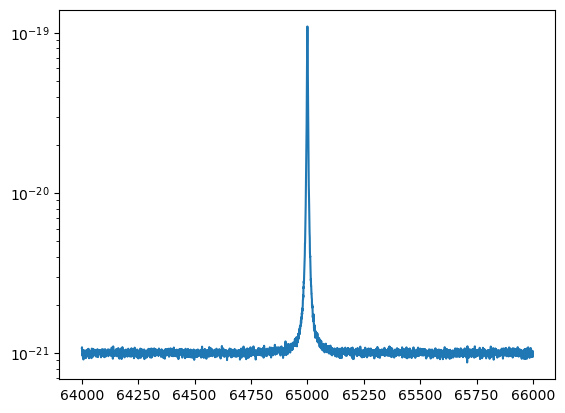

In [32]:
plt.plot(PSD_freq[160000:165000], PSD_noise[160000:165000])
plt.yscale('log')

# Generating data for a non-stationary transfer function oscillator

In this first attempt I will try generating a stationary transfer function, reverse FTing it to time domain, create a modulated timebase then interpolate the displacement trace and finally FT back into the frequency domain. This should be the equivalent of modulating the central frequency of the oscillator. It is probably faster than doing everything in the time domain. First, I will try it on like 100 Hz data and try broadening with a sin modulation to 1 kHz or so. Then I will try it on lower damping data and time it to compare to generating stuff in the time domain.

In [5]:
importlib.reload(su)

num_sims = 1000

# I think saving J and average response the normal way is kind of pointless here but let's do it anyway
# feedback damping values to use
yfb_l = np.array([100, 10])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for yfb in yfb_l:
    for iter in iter_l:
        filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

        # Some set-up
        maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
        numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
        w = np.linspace(0, maxw*2*np.pi, numbins)

        # Generate some random number seeds
        np.random.seed(85655219)
        random_nums = np.random.uniform(0, 1000000, 6*num_sims) # These are the seeds we will use
        np.random.seed(85634442)
        phase = np.random.uniform(0, 1, 2*num_sims)
        

        # Set-up arrays for calculating average response (s in optimal filter/data to fit s to)
        avr_resp = np.zeros(numbins)
        
        # Now generate num_sims different thermally driven particles and add the impulse response
        time = np.linspace(0, numbins/5/10**5/2, numbins)
        for i in range(0, num_sims):
            n = i
            randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
            fm = su.generate_sawtooth_frequency_modulation_impulse(time, iter, phase[i])
            ir = su.impulse_resp_fm(time, time[int(numbins/2)], 10*10**(-10), y, yfb, w0, fm)
            x, t, tm = su.generate_displacement_fm(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir, iter, phase[i])

            # Save time domain response
            mdict = {'x': x, 'ir': ir, 'fm': fm} # saving timetrace, true impulse and true frequency modulation
            su.save_data_hdf5(filename+'/Kicks/' + str(n) + '.hdf5', mdict)

            # Add to average response
            avr_resp += x

        # Save average response to use as template/template fit
        avr_resp /= num_sims
        mdict = {'x':avr_resp}
        su.save_data_hdf5(filename+'/Kicks/avr_resp.hdf5', mdict)

        # Generate 1000 new thermally driven particles with no impulse response to create noise template and to run optimal filter on for comparison

        # Set-up array for noise template (J in optimal filter)
        PSD_noise = np.zeros(int(numbins/2)+1)

        # Create empty array for impulse response because we don't want and impulse
        ir = np.zeros(numbins)

        for i in range(num_sims, 2*num_sims):
            n = i-num_sims
            randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
            x, t, tm = su.generate_displacement_fm(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir, iter, phase[i])
            fm = su.generate_sawtooth_frequency_modulation_impulse(time, iter, phase[i])
            mdict = {'x': x, 'fm': fm} # saving timetrace, true impulse and true frequency modulation
            su.save_data_hdf5(filename+'/Noise/' + str(n) + '.hdf5', mdict)
            # Calculate PSD and add to J
            PSD = scisig.welch(x, fs = 10**6, nperseg = numbins, window = 'boxcar')
            PSD_noise += PSD[1]

        # Save J
        PSD_noise /= num_sims
        PSD_freq = PSD[0]
        mdict = {'J':PSD_noise, 'frequency':PSD_freq}
        su.save_data_hdf5(filename+'/Noise/PSD.hdf5', mdict)

### Okay, I'm going to generate so data with only short timetraces so that I can look at force reconstruction with different impulse size

In [222]:
# Define some parameters

w0 = 80000*2*np.pi # Natural frequency of oscillator
P = 3*10**(-8) # Pressure in mbar
T = 2930 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)
print(4*kb*T*y*M)

Snn = 3*10**(-27) # Displacement noise

0.0002819209824418363
2.4025900020676665e-40


In [225]:
# Simulation
# This block generates the data and saves it
# Calculating num_sims numbers of simulations with and without response
# Also generating average response to impulse and noise template

num_sims = 1000

# feedback damping values to use
yfb_l = np.array([10])*2*np.pi
imp_lens = [61, 71, 81, 91]
for imp_len in imp_lens:
    for yfb in yfb_l:
        filename = 'D:/Simulation Data/240930/implen' + str(imp_len) + '/yfb' + str(round(yfb/2/np.pi))

        # Some set-up
        maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
        numbins = 500# int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
        w = np.linspace(0, maxw*2*np.pi, numbins)
        
        # Generate impulse response
        time = np.linspace(0, numbins/5/10**5/2, numbins)
        #ir = su.impulse_resp(time, time[int(numbins/2)], 8*10*10**(-10), y, yfb, w0) # Same impulse response every time so generate it here
        Fimp = 0.0004/(imp_len - 1)
        ir_l, F = loop_itveldmp(5000, 1, 10, 2*np.pi*80000, 10**(-7), Fimp, imp_len)
        ir = ir_l[::10]

        # Generate some random number seeds
        np.random.seed(85655219)
        random_nums = np.random.uniform(0, 1000000, 6*num_sims) # These are the seeds we will use
        
        # Set-up arrays for calculating average response (s in optimal filter/data to fit s to)
        avr_resp = np.zeros(numbins)
        
        # Now generate num_sims different thermally driven particles and add the impulse response
        for i in range(num_sims):
            randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
            x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir)

            # Save the time domain response
            mdict = {'x': x}
            sio.savemat(filename+'/Kicks/' + str(i) + '.mat', mdict)

            # Add to average response
            avr_resp += x

        # Save average response to use as template/template fit
        avr_resp /= num_sims
        mdict = {'x':avr_resp}
        sio.savemat(filename+'/Kicks/avr_resp.mat', mdict)

        # Generate nums_sims new thermally driven particles with no impulse response to create noise template and to run optimal filter on for comparison

        # Set-up array for noise template (J in optimal filter)
        PSD_noise = np.zeros(int(numbins/2)+1)

        # Create empty array for impulse response because we don't want and impulse
        ir = np.zeros(numbins)

        for i in range(num_sims, 2*num_sims):
            n = i-num_sims
            randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
            x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir)

            # Save the time domain response
            mdict = {'x': x}
            sio.savemat(filename+'/Noise/' + str(n) + '.mat', mdict)

            # Calculate PSD and add to J
            PSD = scisig.welch(x, fs = 10**6, nperseg = numbins)
            PSD_noise += PSD[1]

        # Save J
        PSD_noise /= num_sims
        PSD_freq = PSD[0]
        mdict = {'J':PSD_noise, 'frequency':PSD_freq}
        sio.savemat(filename+'/Noise/PSD.mat', mdict)


In [175]:
0.00004*10*M/(5.3*10**(-28))

3976762.812538288

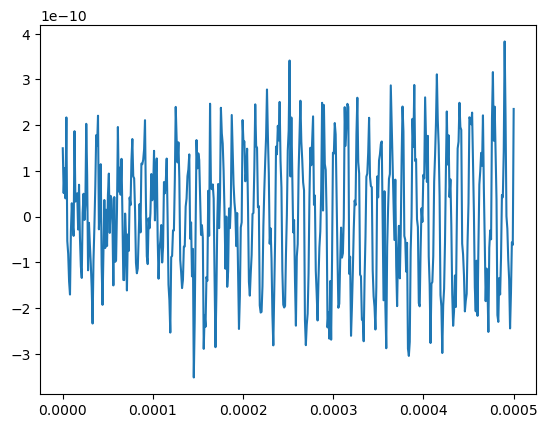

In [73]:
plt.plot(np.linspace(0, 500/10**6, 500), x)

In [30]:
8*10**(-10)*M*np.sqrt(w0**2-yfb**2)/(5.3*10**(-28))

3997877.9965871763

In [220]:
0.000008*M/(5.3*10**(-28))*50

3976762.8125382885

In [193]:
from numba import jit, njit

# Using actual values

@njit
def leapfrog_veldmp(i, buf, y, yfb, w0, dt, Fimp):
    # i is iteration we are on
    # x0 and v0 are initial position and velocity for this step
    # dt is timestep size
    # rnd is random number for this timestep
    tmpbuf = np.zeros(2)
    xint = buf[0] + 0.5*buf[1]*dt
    v1 = buf[1]*(1 - (y + yfb)*dt) - w0**2*xint*dt + Fimp
    x1 = xint + 0.5*v1*dt
    tmpbuf[0] = x1
    tmpbuf[1] = v1
    return tmpbuf

@njit
def loop_itveldmp(n, y, yfb, w0, dtn, Fimp, imp_len):
    buf = np.zeros(2)
    x = np.zeros(n)
    imp = np.zeros(n)
    for i in range(n):
        if int(n/2)<i<int(n/2)+imp_len:
            buf = leapfrog_veldmp(i, buf, y, yfb, w0, dtn, Fimp)
            imp[i] = Fimp
        else:
            buf = leapfrog_veldmp(i, buf, y, yfb, w0, dtn, 0)
        x[i] = buf[0]
    return x, imp

In [214]:
x, F = loop_itveldmp(5000, 1, 10, 2*np.pi*80000, 10**(-7), 0.000008, 51)
x2, F2 = loop_itveldmp(5000, 1, 10, 2*np.pi*80000, 10**(-7), 0.0004, 2)

In [215]:
ir = su.impulse_resp(time, time[int(numbins/2)], 8*10**(-10), y, yfb, w0)

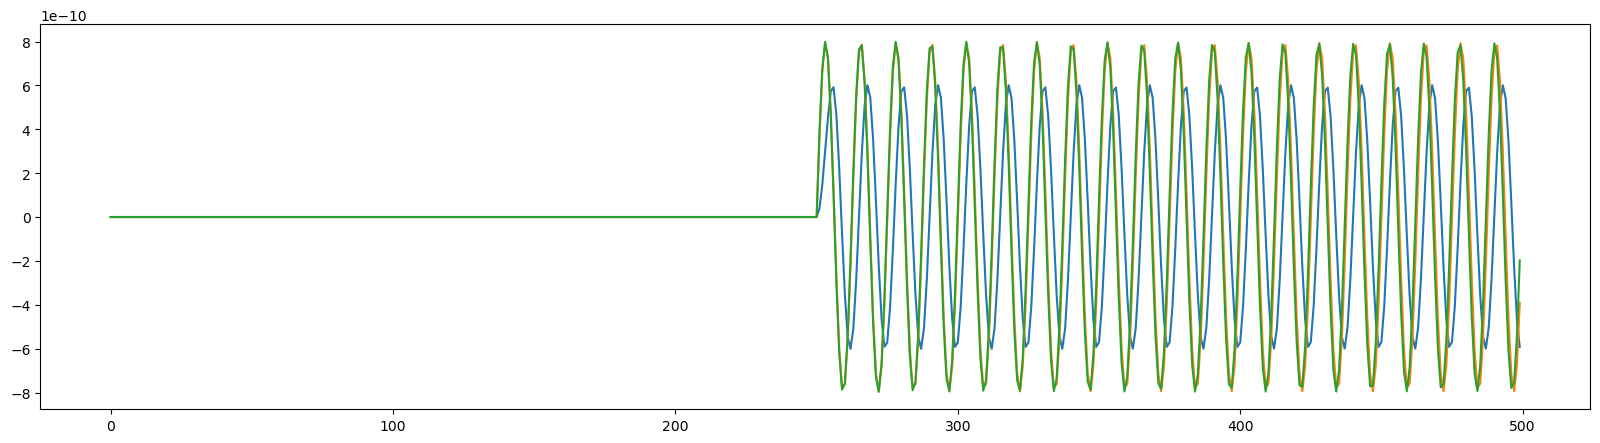

In [216]:
plt.figure(figsize = (20, 5))
plt.plot(x[::10])
#plt.plot(F[::10]/10000)
plt.plot(x2[::10])
#plt.plot(F2[::10]/500000)
plt.plot(ir)

In [166]:
len(x2[::10])

500

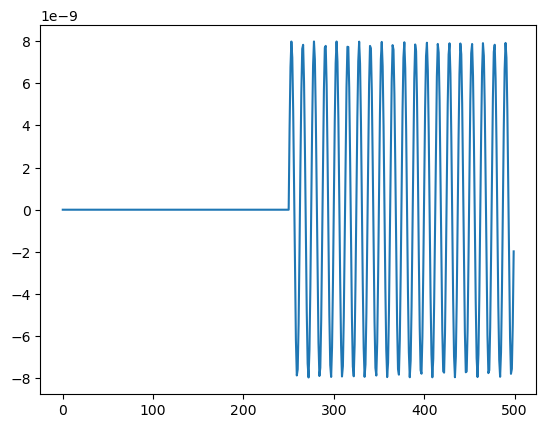

In [140]:
plt.plot(ir)